### Bu veri seti, farklı bölgelerdeki hava durumu ölçümlerini içeriyor.
### Bölge: Ölçümün yapıldığı bölge
### Tarih: Ölçümün yapıldığı tarih
### Saat: Ölçümün yapıldığı saat
### Sıcaklık: Ölçüm anındaki sıcaklık (Celsius)
### Nem Oranı: Ölçüm anındaki nem oranı (%)
### Rüzgar Hızı: Ölçüm anındaki rüzgar hızı (km/saat)
### Hava Durumu: Ölçüm anındaki hava durumu (Açık, Parçalı Bulutlu, Kapalı, Yağmurlu, Karlı, Fırtınalı vb.)¶

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# Bölge Listesi
bolgeler = ['İstanbul', 'Ankara', 'İzmir', 'Antalya', 'Bursa', 'Adana', 'Konya', 'Gaziantep']

# Tarih ve saat listeleri
tarihler = pd.date_range(start='2020-01-01', end='2022-12-31')


# Sıcaklık, nem oranı ve rüzgar hızı için normal dağılım kullanalım.
sicakliklar = np.random.normal(loc=20, scale=10, size=(len(tarihler) * len(bolgeler)))
nem_oranlari = np.random.normal(loc=50, scale=20, size=(len(tarihler) * len(bolgeler)))
ruzgar_hizlari = np.random.normal(loc=10, scale=5, size=(len(tarihler) * len(bolgeler)))


# Hava durumu için rastgele tahmin
hava_durumlari = np.random.choice(['Açık', 'Parçalı Bulutlu', 'Kapalı', 'Yağmurlu', 'Karlı', 'Fırtınalı'],
                                 size=(len(tarihler) * len(bolgeler)))

dataset = pd.DataFrame({
    'Bölge':np.repeat(bolgeler, len(tarihler)),
    'Tarih': np.tile(tarihler, len(bolgeler)),
    'Sıcaklık': sicakliklar,
    'Nem Oranı': nem_oranlari,
    'Rüzgar Hızı': ruzgar_hizlari, 
    'Hava Durumu': hava_durumlari
})


dataset.loc[dataset.sample(frac=0.05).index, 'Sıcaklık'] = np.nan
dataset.loc[dataset.sample(frac=0.05).index, 'Nem Oranı'] = np.nan
dataset.loc[dataset.sample(frac=0.05).index, 'Rüzgar Hızı'] = np.nan

dataset_for_hypothesis = dataset.copy()

dataset.head()

,Bölge,Tarih,Sıcaklık,Nem Oranı,Rüzgar Hızı,Hava Durumu
0,İstanbul,2020-01-01,2.927794,40.281680,13.857469,Karlı
1,İstanbul,2020-01-02,10.303603,85.956853,12.812972,Fırtınalı
2,İstanbul,2020-01-03,7.243945,38.861828,7.739213,Fırtınalı
3,İstanbul,2020-01-04,25.142286,54.627204,4.245647,Kapalı
4,İstanbul,2020-01-05,24.503789,79.845864,9.515083,Karlı


# Veri Analizi

In [3]:
dataset.describe(include='all').T

C:\Users\murat\AppData\Local\Temp\ipykernel_17068\3183102368.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  dataset.describe(include='all').T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Bölge,8768,8,İstanbul,1096,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tarih,8768,1096,2020-01-01 00:00:00,8,2020-01-01,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sıcaklık,8330.0,NaN,NaN,NaN,NaT,NaT,20.021576,9.949133,-10.201905,13.260917,20.09893,26.955779,55.520474
Nem Oranı,8330.0,NaN,NaN,NaN,NaT,NaT,50.08378,20.137783,-20.806917,36.591444,50.183136,63.711067,123.314621
Rüzgar Hızı,8330.0,NaN,NaN,NaN,NaT,NaT,9.95198,4.988752,-8.302796,6.517626,9.948761,13.298052,27.307936
Hava Durumu,8768,6,Karlı,1499,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8768 entries, 0 to 8767
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Bölge        8768 non-null   object        
 1   Tarih        8768 non-null   datetime64[ns]
 2   Sıcaklık     8330 non-null   float64       
 3   Nem Oranı    8330 non-null   float64       
 4   Rüzgar Hızı  8330 non-null   float64       
 5   Hava Durumu  8768 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 411.1+ KB


In [5]:
dataset.isnull().sum()

Bölge            0
Tarih            0
Sıcaklık       438
Nem Oranı      438
Rüzgar Hızı    438
Hava Durumu      0
dtype: int64

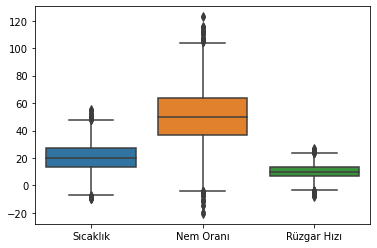

In [6]:
sns.boxplot(data=dataset);

In [7]:
dataset.corr()

,Sıcaklık,Nem Oranı,Rüzgar Hızı
Sıcaklık,1.000000,-0.012234,0.007090
Nem Oranı,-0.012234,1.000000,0.018919
Rüzgar Hızı,0.007090,0.018919,1.000000


In [8]:
dataset.var()

C:\Users\murat\AppData\Local\Temp\ipykernel_17068\2458428038.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataset.var()


Sıcaklık        98.985249
Nem Oranı      405.530288
Rüzgar Hızı     24.887644
dtype: float64

# Veri Ön İşleme

In [9]:
# Kategorik değişkenleri sayısal değişkenlere dönüştürelim.
from sklearn.preprocessing import LabelEncoder

lbe = LabelEncoder()

dataset['Bölge'] = lbe.fit_transform(dataset['Bölge'])
dataset['Hava Durumu'] = lbe.fit_transform(dataset['Hava Durumu'])

In [10]:
# Tarih değişkenini modele uygun hale getirelim.
from datetime import datetime
import time

# her bir tarihi unix zaman damgasına dönüştürelim.
unix_zaman_damgalari = []
for tarih in dataset['Tarih']:
    unix_zaman_damgasi = int(tarih.timestamp())
    unix_zaman_damgalari.append(unix_zaman_damgasi)
dataset['Tarih'] = unix_zaman_damgalari
dataset.head()

,Bölge,Tarih,Sıcaklık,Nem Oranı,Rüzgar Hızı,Hava Durumu
0,6,1577836800,2.927794,40.281680,13.857469,3
1,6,1577923200,10.303603,85.956853,12.812972,1
2,6,1578009600,7.243945,38.861828,7.739213,1
3,6,1578096000,25.142286,54.627204,4.245647,2
4,6,1578182400,24.503789,79.845864,9.515083,3


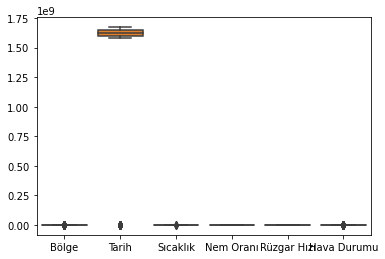

In [11]:
# Aykırı gözlemleri işleyelim.
q1 = dataset['Sıcaklık'].quantile(0.25)
q3 = dataset['Sıcaklık'].quantile(0.75)
iqr = q3 - q1
alt_sinir = q1 - 1.5 * iqr
ust_sinir = q3 + 1.5 * iqr
dataset[dataset['Sıcaklık'] < alt_sinir] = alt_sinir
dataset[dataset['Sıcaklık'] > ust_sinir] = ust_sinir
# ------------------------------------------------------
q1 = dataset['Nem Oranı'].quantile(0.25)
q3 = dataset['Nem Oranı'].quantile(0.75)
iqr = q3 - q1
alt_sinir = q1 - 1.5 * iqr
ust_sinir = q3 + 1.5 * iqr
dataset[dataset['Nem Oranı'] < alt_sinir] = alt_sinir
dataset[dataset['Nem Oranı'] > ust_sinir] = ust_sinir
# ------------------------------------------------------
q1 = dataset['Rüzgar Hızı'].quantile(0.25)
q3 = dataset['Rüzgar Hızı'].quantile(0.75)
iqr = q3 - q1
alt_sinir = q1 - 1.5 * iqr
ust_sinir = q3 + 1.5 * iqr
dataset[dataset['Rüzgar Hızı'] < alt_sinir] = alt_sinir
dataset[dataset['Rüzgar Hızı'] > ust_sinir] = ust_sinir
sns.boxplot(data=dataset);

In [12]:
# Eksik gözlemleri işleyelim.
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error

model = KNNImputer(n_neighbors=5)
filled_data = model.fit_transform(dataset)
filled_data = pd.DataFrame(filled_data, columns=dataset.columns)
filled_data.isnull().sum()

Bölge          0
Tarih          0
Sıcaklık       0
Nem Oranı      0
Rüzgar Hızı    0
Hava Durumu    0
dtype: int64

# ----------------------------------------------------

In [13]:
filled_data.head()

,Bölge,Tarih,Sıcaklık,Nem Oranı,Rüzgar Hızı,Hava Durumu
0,6.0,1.577837e+09,2.927794,40.281680,13.857469,3.0
1,6.0,1.577923e+09,10.303603,85.956853,12.812972,1.0
2,6.0,1.578010e+09,7.243945,38.861828,7.739213,1.0
3,6.0,1.578096e+09,25.142286,54.627204,4.245647,2.0
4,6.0,1.578182e+09,24.503789,79.845864,9.515083,3.0


# Hipotez Testleri

### H0: Bölgelere bağlı olarak sıcaklık farkı yoktur.
### H1: Bölgelere bağlı olarak sıcaklık farkı vardır.

### Hangi hipotez testini uygulayacağımıza varsayımlar üzerinden karar vereceğiz.

In [14]:
# Örneklemi oluşturalım.
deneme = dataset_for_hypothesis.groupby('Bölge')['Sıcaklık'].mean()

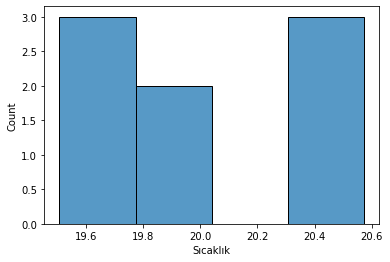

In [15]:
# Normallik Varsayımı
sns.histplot(data=deneme);

### Veriler normal dağılmadığı için parametrik test yapamayız. Non-parametrik test yapabilir. Non-parametrik testlerden hangisini uygulayacağımızı testin hangi senoryalarda kullanıldığına göre karar vereceğiz. Bizim senaryomuzda, Wilcoxon testi kullanabiliriz. Bu test, tek grup içerisinde iki ilişkili örneklemin farklılığını test etmek için kullanılır.

In [16]:
from scipy.stats import wilcoxon

statistic, p_value = wilcoxon(deneme)
alpha = 0.05

if p_value < alpha:
    print('H0 hipotezi reddedilir. Bölgelere bağlı olarak sıcaklık farkı vardır.')
elif p_value > alpha:
    print('H1 hipotezi reddedilmez. Bölgelere bağlı olarak sıcaklık farkı yoktur.')

H0 hipotezi reddedilir. Bölgelere bağlı olarak sıcaklık farkı vardır.


# ---------------------------------------------------------------------

In [17]:
dataset_for_hypothesis.head()

,Bölge,Tarih,Sıcaklık,Nem Oranı,Rüzgar Hızı,Hava Durumu
0,İstanbul,2020-01-01,2.927794,40.281680,13.857469,Karlı
1,İstanbul,2020-01-02,10.303603,85.956853,12.812972,Fırtınalı
2,İstanbul,2020-01-03,7.243945,38.861828,7.739213,Fırtınalı
3,İstanbul,2020-01-04,25.142286,54.627204,4.245647,Kapalı
4,İstanbul,2020-01-05,24.503789,79.845864,9.515083,Karlı


### H0: İstanbul ile Antalya arasında hava durumu benzerliği yoktur.
### H1: İstanbul ile Antalya arasında hava durumu benzerliği vardır.

In [18]:
# Bölge bilgisine göre Hava Durumunu değerlendirebilmek için Hava Durumunu sayısal değişkene çevirelim.

dataset_for_hypothesis['Hava Durumu'].unique()
lbe = LabelEncoder()
dataset_for_hypothesis['Hava Durumu'] = lbe.fit_transform(dataset_for_hypothesis['Hava Durumu'])
dataset_for_hypothesis['Hava Durumu'].unique()
## Karlı:3, Fırtınalı:1, Yağmurlu:5, Açık:0, Parçalı Bulutlu:4, Kapalı:2 

array([3, 1, 2, 0, 4, 5])

In [19]:
istanbul = dataset_for_hypothesis.loc[dataset_for_hypothesis['Bölge'] == 'İstanbul', 'Hava Durumu']
antalya = dataset_for_hypothesis.loc[dataset_for_hypothesis['Bölge'] == 'Antalya', 'Hava Durumu']

In [20]:
# Normallik varsayımını test etmek için shapiro-wilk testi yapacağız.
from scipy.stats import shapiro
alpha = 0.05

stat, p_value = shapiro(istanbul)
if p_value < alpha:
    print('H0 hipotezi reddedilir. İstanbul örneklemi normal dağılıma uymuyor.')
else:
    print('H0 hipotezi reddedilmez. İstanbul normal dağılıma uyuyor.')
    
stat, p_value = shapiro(antalya)
if p_value < alpha:
    print('H0 hipotezi reddedilir. Antalya örneklemi normal dağılıma uymuyor.')
else:
    print('H0 hipotezi reddedilmez. Antalya örneklemi normal dağılıma uyuyor.')

H0 hipotezi reddedilir. İstanbul örneklemi normal dağılıma uymuyor.
H0 hipotezi reddedilir. Antalya örneklemi normal dağılıma uymuyor.


### Normallik varsayımı sağlanmadığı için Non-parametrik test yapacağız. Mann Whitney U testi yapılabilir. Bu test, iki grup arasında farklılık olup olmadığını test etmek için kullanılır.

In [21]:
from scipy.stats import mannwhitneyu
alpha = 0.05

t_stat, p_value = mannwhitneyu(istanbul, antalya)
if p_value < alpha:
    print('H0 reddedilir. İstanbul ve Antalya arasında hava durumu benzerliği yoktur.')
else:
    print('H0 reddedilmez. İstanbul ve Antalya arasında hava durumu benzerliği yoktur.')

H0 reddedilmez. İstanbul ve Antalya arasında hava durumu benzerliği yoktur.


# ------------------------------------------------------------------------------------------

In [22]:
filled_data.head()

,Bölge,Tarih,Sıcaklık,Nem Oranı,Rüzgar Hızı,Hava Durumu
0,6.0,1.577837e+09,2.927794,40.281680,13.857469,3.0
1,6.0,1.577923e+09,10.303603,85.956853,12.812972,1.0
2,6.0,1.578010e+09,7.243945,38.861828,7.739213,1.0
3,6.0,1.578096e+09,25.142286,54.627204,4.245647,2.0
4,6.0,1.578182e+09,24.503789,79.845864,9.515083,3.0


# Model İşlemleri

In [23]:
# bağımlı ve bağımsız değişkenleri oluşturalım.
X = filled_data[['Bölge', 'Tarih', 'Sıcaklık', 'Nem Oranı', 'Rüzgar Hızı']]
y = filled_data['Hava Durumu']

### Şimdi ise, bağımlı değişkenimizin (y) normallik varsayımına uyuyor mu onu test edelim. Bunun sebebi, eğer bağımlı değişkenimiz normallik varsayımına uyuyor ise doğrusal regresyon modellerini kullanacağız. Eğer bağımlı değişkenimiz normallik varsayımına uymuyor ise doğrusal olmayan regresyon modellerini kullanacağız.

In [24]:
alpha = 0.05

statistic, p_value = shapiro(y)
if p_value < alpha:
    print('H0 hipotezi reddedilir. Bağımlı değişken normal dağılmıyor.')
else:
    print('H0 hipotezi reddedilmez. Bağımlı değişken normal dağılıyor.')

H0 hipotezi reddedilir. Bağımlı değişken normal dağılmıyor.


C:\Users\murat\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### Bağımlı değişken normal dağılmadığı için, doğrusal olmayan regresyon modeli kuracağız. KNN (en yakın komşular) modeli kurabiliriz.

In [25]:
# eğtim ve test setlerini ayıralım.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Modeli oluşturalım ve eğitelim.
model = KNeighborsRegressor().fit(X_train, y_train)

In [27]:
# Tahmin yapalım.
y_pred = model.predict(X_test)

In [28]:
# Modeli Değerlendirelim.
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print('R-Kare Değeri: ', r2)
print('MSE Değeri: ', mse) 

R-Kare Değeri:  0.24472071213983826
MSE Değeri:  3.376716077537058


# Model Tuning İşlemi

### Şimdi ise modelimiz için en iyi hiperparametreleri bularak modelimizi optimize edelim.

In [29]:
knn = KNeighborsRegressor()
params = {
    'n_neighbors':[3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'leaf_size': [10, 20, 30, 40, 50]
}
grid_search = GridSearchCV(estimator=knn, param_grid=params, cv=5)
grid_search.fit(X_train, y_train)

print('Best Params: ', grid_search.best_params_)
print('Best Score: ', grid_search.best_score_)

Best Params:  {'algorithm': 'brute', 'leaf_size': 10, 'metric': 'chebyshev', 'n_neighbors': 11, 'weights': 'uniform'}
Best Score:  0.5910579842577002


In [49]:
# random_state için en iyi değeri bulalım.
random_states = [0, 10, 20, 42, 60, 80, 100]

for element in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=element)
    model = KNeighborsRegressor(algorithm='brute', leaf_size=10, metric='chebyshev', n_neighbors=11, weights='uniform').fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred[0:len(y_test)])
    print(f'random_state={element} için R-Kare Değeri: {r2}')

random_state=0 için R-Kare Değeri: 0.5742557597888177
random_state=10 için R-Kare Değeri: 0.5614684135119543
random_state=20 için R-Kare Değeri: 0.5575243228709472
random_state=42 için R-Kare Değeri: 0.31544451998604117
random_state=60 için R-Kare Değeri: 0.5724585062785463
random_state=80 için R-Kare Değeri: 0.4249910918689449
random_state=100 için R-Kare Değeri: 0.5646083827014521


In [51]:
# En iyi değerler için modelimizi tekrar oluşturalım.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = KNeighborsRegressor(algorithm='brute', leaf_size=10, metric='chebyshev', n_neighbors=11, weights='uniform').fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('R-Kare Değeri: ', r2)

R-Kare Değeri:  0.5742557597888177
